In [2]:
import botorch
import torch
import matlab.engine
import io
import os
import numpy as np
import math
import sys
sys.path.append(os.path.abspath('..'))

eng = matlab.engine.start_matlab()
eng.cd(r'./MPC_BO_Thickness_ver7.0_CASE3', nargout=0)

In [3]:
# Now, the second return is 1 if succeed, 0 otherwise
def problem_wrapper(dA=1.5):
    def problem(Tref, Iref, Aref1, Aref2, Aref3):
        res = eng.RT_control_return(Tref, Iref, matlab.double([[Aref1],[Aref2],[Aref3]]), dA, stdout=io.StringIO())
        return torch.from_numpy(np.asarray(res))
    return problem

In [4]:
tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}
SMOKE_TEST = os.environ.get("SMOKE_TEST")

In [5]:
from botorch.models.gp_regression import FixedNoiseGP
from botorch.models.transforms.outcome import Standardize
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.transforms import normalize, unnormalize
from gpytorch.mlls.sum_marginal_log_likelihood import ExactMarginalLogLikelihood

from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement
from botorch.acquisition.objective import MCAcquisitionObjective
from botorch.optim.optimize import optimize_acqf

BATCH_SIZE = 1
NUM_RESTARTS = 256 if not SMOKE_TEST else 2
RAW_SAMPLES = 512 if not SMOKE_TEST else 4

bounds = torch.tensor([[35, 1500, 1.4016/2., -14.4395*2., 12.5570/2.],
                       [65, 3000, 1.4016*2., -14.4395/2., 12.5570*2.]]).to(**tkwargs)
#bounds = torch.tensor([[35, 1500, 1.4016*1.0, -14.4395*1.5, 12.5570*1.0],
#                       [65, 3000, 1.4016*1.5, -14.4395*1.0, 12.5570*1.5]]).to(**tkwargs)
standard_bounds = torch.zeros(2, bounds.shape[1], **tkwargs)
standard_bounds[1] = 1
# need to also include the bounds for the run idx
# though this is fixed during AF optimization
bounds = torch.cat((bounds, torch.tensor([[0],[100]]).to(**tkwargs)), dim=-1)
bounds[1, -1] = 1.
# we do not normalized the time (index)
standard_bounds = torch.cat((standard_bounds, torch.tensor([[0],[100]]).to(**tkwargs)), dim=-1)
# extra bounds for time (index) to make the AF optimization happy


In [6]:
from custom_kernels import PosEncode
from covar_module import get_spatio_temp_kernel
NOISE_SE = torch.tensor([0.0] * 1, **tkwargs)

def generate_initial_data(problem, n=7, guaratee_feasible=True):
    # generate training data
    train_x = draw_sobol_samples(bounds=bounds[:,:-1], n=n, q=1).squeeze(1)
    train_obj_plain = torch.cat([problem(*_.tolist()).reshape(1,-1) for _ in train_x], dim=0)
    train_obj_true = train_obj_plain[..., :-1]
    train_obj = train_obj_true + torch.randn_like(train_obj_true) * NOISE_SE
    if guaratee_feasible:
        final_train_x = torch.zeros((0, train_x.shape[-1]))
        final_train_obj_true = torch.zeros((0, train_obj_true.shape[-1]))
        final_train_obj = torch.zeros_like(final_train_obj_true)
        mask = (train_obj_plain[:, -1] == 1).reshape(-1)
        final_train_x = torch.cat((final_train_x, train_x[mask, :]), dim=0)
        final_train_obj_true = torch.cat((final_train_obj_true, train_obj_true[mask, :]), dim=0)
        final_train_obj = torch.cat((final_train_obj, train_obj[mask, :]), dim=0)
        n = n-final_train_x.shape[0]
        while n:
            train_x = draw_sobol_samples(bounds=bounds[:,:-1], n=n, q=1).squeeze(1)
            train_obj_plain = torch.cat([problem(*_.tolist()).reshape(1,-1) for _ in train_x], dim=0)
            train_obj_true = train_obj_plain[..., :-1]
            train_obj = train_obj_true + torch.randn_like(train_obj_true) * NOISE_SE
            mask = (train_obj_plain[:, -1] == 1).reshape(-1)
            final_train_x = torch.cat((final_train_x, train_x[mask, :]), dim=0)
            final_train_obj_true = torch.cat((final_train_obj_true, train_obj_true[mask, :]), dim=0)
            final_train_obj = torch.cat((final_train_obj, train_obj[mask, :]), dim=0)
            n = n-train_x[mask, :].shape[0]
        return final_train_x, final_train_obj, final_train_obj_true

    return train_x, train_obj, train_obj_true


def initialize_model(train_x, 
                     train_obj, 
                     input_trans=None, 
                     input_trans_args=None,
                     type_of_forgetting='UI',
                     forgetting_factor=0.03):
    # define models for objective and constraint
    train_x = normalize(train_x, bounds)
    models = []
    for i in range(train_obj.shape[-1]):
        train_y = train_obj[..., i : i + 1]
        train_yvar = torch.full_like(train_y, NOISE_SE[i] ** 2)
        covar = get_spatio_temp_kernel(train_x,
                                       train_y, 
                                       type_of_forgetting=type_of_forgetting,
                                       forgetting_factor=forgetting_factor)
        if input_trans is not None:
            models.append(FixedNoiseGP(train_x,
                                       train_y, 
                                       train_yvar, 
                                       covar_module=covar,
                                       outcome_transform=Standardize(m=1), 
                                       input_transform=input_trans(**input_trans_args)))
        else:         
            models.append(FixedNoiseGP(train_x, 
                                       train_y, 
                                       train_yvar,
                                       covar_module=covar, 
                                       outcome_transform=Standardize(m=1)))
    model = models[0] # in this case it is single objective!!!
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    return mll, model

In [7]:
# define a MCMultiOutputObjective convert thickness and time to
# (thickness-ref_thickness)**2 and (time-ref_time)**2

class obj_convert(MCAcquisitionObjective):
    def __init__(self):
        super().__init__()
    
    def forward(self, samples, X = None):
        ans = -(samples-1.)**2
        if ans.shape[-1] == 1:
            ans = ans.squeeze(-1)
        return ans # just the thickness


def optimize_qnehvi_and_get_observation(model, train_x, train_obj, sampler, problem, run_num):
    """Optimizes the qEHVI acquisition function, and returns a new candidate and observation."""
    batch = BATCH_SIZE
    # build the casadi optimization for MPC retry here
    final_new_x = torch.zeros((0, train_x.shape[-1])).to(train_x)
    final_new_obj = torch.zeros((0, train_obj.shape[-1])).to(train_obj)
    final_new_obj_true = torch.zeros((0, train_obj.shape[-1])).to(train_obj)

    # check how many recalculation we did....
    retry_count = 0
    while batch and retry_count <= BATCH_SIZE*100:
        retry_count += batch
        # partition non-dominated space into disjoint rectangles
        acq_func = qNoisyExpectedImprovement(
            model=model,
            objective=obj_convert(),
            X_baseline=normalize(train_x, bounds),
            prune_baseline=True,  # prune baseline points that have estimated zero probability of being Pareto optimal
            sampler=sampler,
        )
        # optimize
        candidates, _ = optimize_acqf(
            acq_function=acq_func,
            bounds=standard_bounds,
            fixed_features={bounds.shape[-1]-1: float(run_num)},
            q=batch,
            num_restarts=NUM_RESTARTS,
            raw_samples=RAW_SAMPLES,  # used for intialization heuristic
            options={"batch_limit": 5, "maxiter": 1000},
            sequential=True,
        )
        # observe new values
        new_x = unnormalize(candidates[...,:-1].detach(), bounds=bounds[:,:-1])
        new_obj_true = torch.cat([problem(*_.tolist()).reshape(1,-1) for _ in new_x], dim=0)
        #print(new_obj_true)
        # check solution status
        succeed = new_obj_true[:, -1] == 1.
        #print(succeed)
        new_x = new_x[succeed.reshape(-1), :]
        #print(new_x.shape)
        candidates = candidates[succeed.reshape(-1), :]
        # chop donw the final dimension, which is just the MPC optimization succeed status
        new_obj_true = new_obj_true[succeed.reshape(-1), :-1]
        new_obj = new_obj_true + torch.randn_like(new_obj_true) * NOISE_SE
        new_x = torch.cat((new_x, candidates[...,-1].detach().unsqueeze(-1)), dim=-1)

        final_new_x = torch.cat([final_new_x, new_x], dim=0)
        final_new_obj = torch.cat([final_new_obj, new_obj], dim=0)
        final_new_obj_true = torch.cat([final_new_obj_true, new_obj_true], dim=0)

        # check if we need more calculation...
        batch = batch - new_x.shape[0]

    return final_new_x, final_new_obj, final_new_obj_true, retry_count <= BATCH_SIZE*10

In [8]:
import pickle
with open('../data_init.pkl', 'rb') as fp:
    old_res = pickle.load(fp)[0]


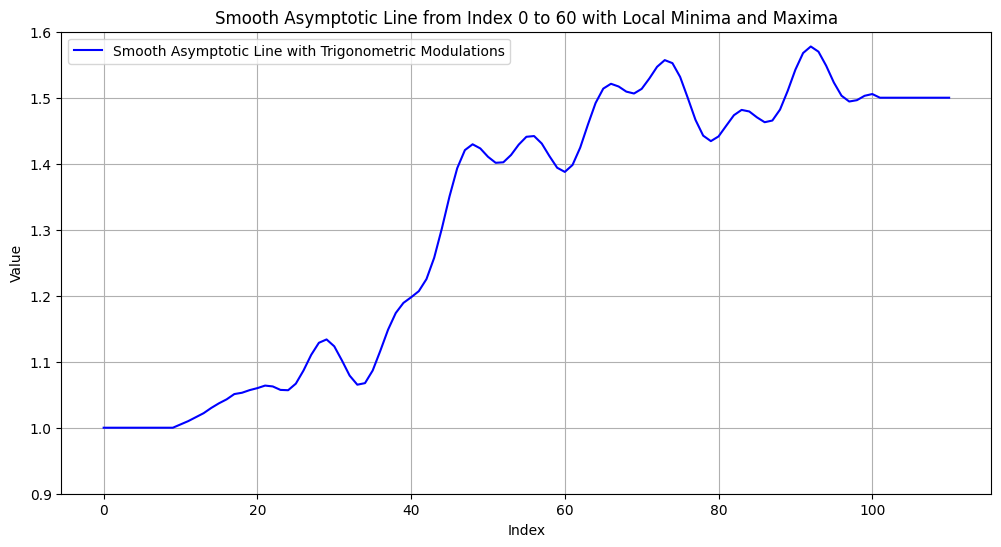

In [12]:
# Define the indices and the modified function with trigonometric functions added to create local minima and maxima
import matplotlib.pyplot as plt
import numpy as np
ori_indeices = np.array(range(-10, 81))
indices =ori_indeices*1.4
line = 1 + (0.5 / (1 + np.exp(-0.1 * (indices - 30)))) + 0.05 * np.sin(0.2 * indices) + 0.03 * np.cos(0.5 * indices)
line = [1.,1.,1.,1.,1.]*2 + line.tolist()+[1.5] * 10
line[10] = 1.005
line[11] = 1.01
line[12] = 1.016
line[13] = 1.022
line[14] = 1.030
line[15] = 1.037
line[16] = 1.043
line[17] = 1.051
line[18] = 1.053
line[19] = 1.057
line[20] = 1.060
# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(range(len(line)), line, label='Smooth Asymptotic Line with Trigonometric Modulations', color='blue')

# Setting the limit for y-axis to make the asymptotic nature clearer
plt.ylim(0.9, 1.6)

# Annotate the asymptotic values
#plt.annotate('Asymptotic value = 1', xy=(0, 1), xytext=(5, 1.1),
#             arrowprops=dict(facecolor='black', shrink=0.05))
#plt.annotate('Asymptotic value = 1.5', xy=(60, 1.5), xytext=(45, 1.55),
#             arrowprops=dict(facecolor='black', shrink=0.05))

# Set the range for the x-axis
#plt.xlim(0, 81)

# Label the axes
plt.xlabel('Index')
plt.ylabel('Value')

# Add a title and a legend
plt.title('Smooth Asymptotic Line from Index 0 to 60 with Local Minima and Maxima')
plt.legend()

# Display the plot
plt.grid(True)
plt.show()


In [13]:
def same_init(n=5):
    cur_problem = problem_wrapper(1.0)
    #train_init = generate_initial_data(cur_problem, n=n)
    train_init = (old_res['outcome_X'][:10,:-1], old_res['outcome_Y'][:10,:], old_res['outcome_Y'][:10,:])
    def BO_wrapper_with_same_init(embed_dim,
                                  reduce_to_one, 
                                  batch_num,
                                  type_of_forgetting='UI',
                                  forgetting_factor=0.03):
        import time
        import warnings

        from botorch.exceptions import BadInitialCandidatesWarning
        from botorch.fit import fit_gpytorch_model
        from botorch.sampling import SobolQMCNormalSampler

        warnings.filterwarnings("ignore", category=BadInitialCandidatesWarning)
        warnings.filterwarnings("ignore", category=RuntimeWarning)

        N_BATCH = batch_num if not SMOKE_TEST else 10        
        MC_SAMPLES = 512 if not SMOKE_TEST else 16

        verbose = True

        while True:
            restart_flag = False
            # call helper functions to generate initial training data and initialize model
            res = {}
            train_x_qnehvi, train_obj_qnehvi, train_obj_true_qnehvi = train_init
            # need to assign index of 0, indicating we have data of the un-drifted model
            train_x_qnehvi = torch.cat((train_x_qnehvi, torch.zeros((train_x_qnehvi.shape[0], 1)).to(**tkwargs)), dim=-1)
            if embed_dim is not None:
                mll_qnehvi, model_qnehvi = initialize_model(train_x_qnehvi, train_obj_qnehvi, 
                                                            PosEncode, {"positional_emb_dim": embed_dim, "reduce_to_one": reduce_to_one, "tkwargs": tkwargs},
                                                            type_of_forgetting=type_of_forgetting, forgetting_factor=forgetting_factor)
            else:
                mll_qnehvi, model_qnehvi = initialize_model(train_x_qnehvi, train_obj_qnehvi,
                                                            type_of_forgetting=type_of_forgetting, forgetting_factor=forgetting_factor)

            # run N_BATCH rounds of BayesOpt after the initial random batch
            for iteration in range(2, N_BATCH + 1):

                t0 = time.monotonic()

                # fit the models
                #for name, _ in mll_qnehvi.named_parameters():
                #    print(name, _)
                fit_gpytorch_model(mll_qnehvi)
                #for name, _ in mll_qnehvi.named_parameters():
                #    print(name, _)

                # define the qEI and qNEI acquisition modules using a QMC sampler
                qnehvi_sampler = SobolQMCNormalSampler(MC_SAMPLES)
                #if iteration > 20:
                #    run_num = 20 - 1
                #else:
                #    run_num = iteration-1
                #dA_init = 1.0
                #dA_final = 1.5
                #No_run_max = 20
                #dA = dA_init - (dA_init - dA_final)/(No_run_max-1)*(run_num)
                
                run_num = iteration-1
                #dA = 0.5 /(1 + math.exp(-0.15*(run_num-50-1)))+1            
                #dA = 0.5 /(1 + math.exp(-0.10*(run_num-50-1)))+1            
                dA = line[run_num]
                print('\n', dA)
                cur_problem = problem_wrapper(dA)

                # optimize acquisition functions and get new observations
                (
                    new_x_qnehvi,
                    new_obj_qnehvi,
                    new_obj_true_qnehvi,
                    exit_status,
                ) = optimize_qnehvi_and_get_observation(model_qnehvi, train_x_qnehvi, train_obj_qnehvi, qnehvi_sampler, cur_problem, run_num)

                # if we failed to optimize several times (currently BATCH_SIZE*100), we just dump this trajectory!
                if not exit_status and new_x_qnehvi.shape[0] != BATCH_SIZE:
                    restart_flag = True
                    continue
                # update training points
                train_x_qnehvi = torch.cat([train_x_qnehvi, new_x_qnehvi])
                train_obj_qnehvi = torch.cat([train_obj_qnehvi, new_obj_qnehvi])
                train_obj_true_qnehvi = torch.cat([train_obj_true_qnehvi, new_obj_true_qnehvi])

                # reinitialize the models so they are ready for fitting on next iteration
                # Note: we find improved performance from not warm starting the model hyperparameters
                # using the hyperparameters from the previous iteration
                if embed_dim is not None:
                    mll_qnehvi, model_qnehvi = initialize_model(train_x_qnehvi, train_obj_qnehvi, 
                                                                PosEncode, {"positional_emb_dim": embed_dim, "reduce_to_one": reduce_to_one, "tkwargs": tkwargs},
                                                                type_of_forgetting=type_of_forgetting, forgetting_factor=forgetting_factor)
                else:
                    mll_qnehvi, model_qnehvi = initialize_model(train_x_qnehvi, train_obj_qnehvi,
                                                                type_of_forgetting=type_of_forgetting, forgetting_factor=forgetting_factor)

                t1 = time.monotonic()

                if verbose:
                    print(
                        f"\nBatch {iteration:>2}: "
                        f"time = {t1-t0:>4.2f}",
                        end="",
                    )
                else:
                    print(".", end="")
            if restart_flag:
                continue
            res["outcome_X"] = train_x_qnehvi
            res["outcome_Y"] = train_obj_qnehvi
            return res
    return BO_wrapper_with_same_init

In [14]:
run_drift = same_init(10)

In [ ]:
pos_emb_res = []
for _ in range(5):
    pos_emb_res.append(run_drift(128, True, 100, 'UI_learning', 0.03)) # TVBO Positional Encoding
    

In [ ]:
# the first argument is the dimension of positional encoding, must be even
# if None, then the index of the run will be used
# the indices of all the initial data set are set as 0 (perfect environment)
# the second is if we map the positional encoding dimension to 1
# the third is the total number of runs, excluding the first 5 init runs.
# the fourth is the method of TVBO (the temporal kernel)
# the fifth is the parameter of the temporal kernel, the original paper used 0.03
res = run_drift(None, False, 30, 'UI', 0.03)